# Индивиуальное задание

## Этап  № 5. Исследование вероятности экспозиции совместно с вероятностью блокировки на основе модели антенн

_Выполнил_ студент 2 курса<br>
учебной группы НММ-02-22<br>
Мулин Иван

### Цели
Построить согласно описанному ниже алгоритму имитационную модель, позволяющую рассчитать вероятность блокировки линии прямой видимости, и сравнить полученную характеристику с результатами математической модели.

### Задача

В условиях предыдущего задания №4, на двух точках, между которыми производится проверка прямой видимости, формируется диаграмма направленности, задающаяся вектором направления и углом. Предполагается, что если для обеих из рассматриваемых точек вторая точка лежит внутри сектора, описанного вектором и углом и линия прямой видимости между ними не заблокирована, то точки находятся в области видимости друг друга.

При условии, что направление вектора диаграммы задается случайно равномерно распределенной величиной от $0$ до $ 2\pi $, а угол является  константой, определить находятся ли рассматриваемые точки в области видимости друг друга.

На основе 1000 реализаций определить вероятность нахождения точек в области видимости друг друга. Полученный результат сравнить с результатами математической модели.

### Ход работы

Подключаем нужные и ненужные библиотеки. После этого вводим константы, данные по условию.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy.linalg import norm
from numpy import arcsin, arccos, dot, cross, pi

In [2]:
SquareWidth = 10
PoissonParameter = 0.3
Radius = 0.5
TRDistance = 3
Points = np.array

angles = np.linspace(0, 2 * pi, 80)
VisionAngle = np.random.uniform(0.001, pi/3)

Опишем функции, необходимые для построения модели.

In [3]:
# Functions for drawing

def DrawCircle(x0, y0, r, hue="#eb3437"):
    """
    Draws a circle on a plot.
    """
    global angles
    xs = x0 + r*np.cos(angles)
    ys = y0 + r*np.sin(angles)
    plt.plot(x0, y0, color = hue, marker=".")
    plt.plot(xs, ys, color = hue)
    plt.fill(xs, ys, color = hue+"80") # 50% transparency

def DrawRectangle(Rectangle, hue="#ebcc34"):
    """
    Draws a rectangle.
    """
    xs, ys = Rectangle[0], Rectangle[1]
    plt.plot(xs, ys, color=hue)
    plt.fill(xs, ys, color=hue+"80")

def DrawAngle(x0, y0, angle, mu, hue1="#f5aa42"):
    """
    Draws angle of vision at (x0, y0) rotated by mu radians.
    """
    x1, y1 = x0 + np.cos(mu), y0 + np.sin(mu)
    x2, y2 = x0 + np.cos(mu - angle), y0 + np.sin(mu - angle)
    plt.plot((x0, x1), (y0, y1), color=hue1)
    plt.plot((x0, x2), (y0, y2), color=hue1)

In [4]:
# Algebraic functions

def sign(x):
    """
    A mathematical sgn(x).
    """
    if x == 0:
        return 0
    return x/abs(x)

def CalDistance(L, P):
    """
    Calculates distance between line Ax+By+C=0 and point P=(x0 y0).
    (L=(A B C).)
    """
    Q = L[:-1]
    R = np.append( np.transpose(P), 1)
    return abs( np.matmul(L, R) ) / norm(Q)

def GetLine(x1, y1, x2, y2):
    """
    Calculates vector (A B C) for a line Ax+By+C=0.
    """
    det = x1*y2 - x2*y1
    if det != 0: # y=kx+s, s!=0
        A = (y1-y2) / det
        B = (x2-x1) / det
        return np.array([A, B, 1])
    
    if x1**2 + y1**2 == 0 or x1==0 or y1==0: # if x1=y1, that is not a line!
        return np.array([0, 1, 0])
        
    # ...then it is y=kx, k!=0
    B = -1
    A = y1/x1
    return np.array([A, B, 0])

def PointInSection(b, c):
    """
    Determines whether point is in section. Angles b, c to be passed.
    """
    return (0 <= b) * (b <= c) 

In [5]:
def PoissonProcessInitializer(lam, area, precision=0.0000001):
    """
    Initializes Poisson process.
    """
    amount = np.random.poisson(lam * area**2)
    x = np.random.uniform(0, area, size=amount)
    y = np.random.uniform(0, area, size=amount)
    x -= x % precision
    y -= y % precision
    return x, y

In [6]:
class Diagram:
    """
    Diagram is a line of sight with sectors of vision.
    """
    def __init__(self,\
                 p1x, p2x, p1y, p2y,\
                 mu1, mu2, angle\
                ):
        # Line of sight stuff
        self.distance = norm([p2x-p1x, p2y-p1y])
        self.midline = ([p1x, p2x], [p1y, p2y])
        self.incline = sign( arcsin((p2y-p1y)/self.distance) ) * arccos((p2x-p1x)/self.distance)
        self.rect = self.__GetRectangle__()

        # Sectors of vision stuff
        self.VSangle, self.mu1, self.mu2 = angle, mu1, mu2
        mu1 += self.incline
        mu2 += self.incline

        
    def __GetRectangle__(self):
        """
        Calculates rectangle ABCD's coordinates.
        """
        global Radius
        W = pi/2 - self.incline
        RC, RS = Radius*np.cos(W), Radius*np.sin(W)
    
        Ax, Ay = p1x - RC, p1y + RS
        Bx, By = p1x + RC, p1y - RS
        Cx, Cy = p2x + RC, p2y - RS
        Dx, Dy = p2x - RC, p2y + RS
        return ([Ax, Bx, Cx, Dx, Ax], [Ay, By, Cy, Dy, Ay])

    
    def Draw(self, LoSHue="#ebcc34", miglineHue="#34eb4f", VSHue="#f5aa42"):
        """
        Draws a line of sight.
        Also draws vision sectors.
        """
        DrawRectangle(self.rect, LoSHue)
        plt.plot(self.midline[0], self.midline[1], marker=".", color=miglineHue, linestyle="dashed")

        DrawAngle(self.midline[0][0], self.midline[1][0], self.VSangle, self.mu1+self.incline, VSHue)
        DrawAngle(self.midline[0][1], self.midline[1][1], self.VSangle, self.mu2+self.incline, VSHue)

In [7]:
def CheckConnection(Diag: Diagram, BlockerCentres, isOfOtherDistance, debugging=0):
    """
    Will count how many collisions happened.
    If debugging=True, it will draw blockators with proper colors and say where it is.
    """
    global Radius, TRDistance
    collisions = 0
    D = 2*Radius

    Rect = Diag.rect
    MidX, MidY = Diag.midline
    if not isOfOtherDistance:
        Diag.distance = TRDistance
    
    Midline = GetLine(MidX[0], MidY[0], MidX[1], MidY[1])
    Sides = GetLine(MidX[0], MidY[0], Rect[0][0], Rect[1][0]),\
            GetLine(MidX[1], MidY[1], Rect[0][3], Rect[1][3])

    P1OutofSection = not PointInSection(Diag.mu1, Diag.VSangle)
    P2OutofSection = not PointInSection(Diag.mu2-pi, Diag.VSangle)
    if P1OutofSection or P2OutofSection:
        for p in BlockerCentres:
            if debugging:
                DrawCircle(p[0], p[1], Radius, "#c7e63e")
        if P1OutofSection and P2OutofSection:
            return -3
        elif P2OutofSection:
            return -2
        return -1
            
    
    for p in BlockerCentres:
        t = CalDistance(Midline, p)
        l1, l2 = CalDistance(Sides[0], p), CalDistance(Sides[1], p)
        lmin = min(l1, l2)
        
        L = l1+l2
        L -= (L % 0.0000001)
        # I added L because 1.4+1.6=3.0000000000000001 messes all up
        
        if L>Diag.distance and Radius>lmin:
            r = np.sqrt( Radius**2 - lmin**2 )
            
            if t<r+Radius:
                collisions += 1
                if debugging:
                    print(f"Blockator type 1 at {p}")
                    DrawCircle(p[0], p[1], Radius, "#eb3446")
            
            else: # non-colliding blockator
                if debugging:
                    DrawCircle(p[0], p[1], Radius, "#424ef5")
        elif L<=Diag.distance and t<D:
                collisions += 1
                if debugging:
                    print(f"Blockator type 2 at {p}")
                    DrawCircle(p[0], p[1], Radius, "#eb3446")
        else: # non-colliding blockator
            if debugging:
                DrawCircle(p[0], p[1], Radius, "#424ef5")
    return collisions

### Тестовая модель
Участок кода ниже предназначен для проверки работы написанных функций.

Blockator type 2 at (3, 1.4)
Line of sight is blocked 1 times


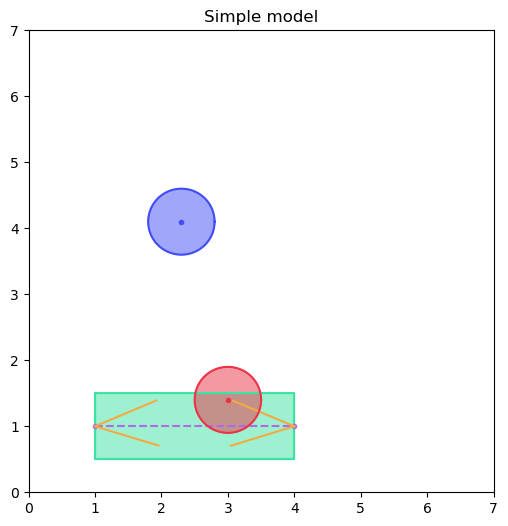

In [8]:
W = 0.3
p1x, p1y = 1, 1
p2x, p2y = 4, 1
p1a, p2a = 0.4, pi+0.3
# p1a, p2a = np.random.uniform(0, 2*pi), np.random.uniform(0, 2*pi)

diagram = Diagram(p1x, p2x, p1y, p2y, p1a, p2a, VisionAngle)
#Blockators = [(4.3, 1.6), (2.3, 4.1)]
Blockators = [(3, 1.4), (2.3, 4.1)]

plt.figure(dpi=100, figsize=(6, 6))
plt.title("Simple model")

diagram.Draw("#3de3a3", "#ae6be8")

connection = CheckConnection(diagram, Blockators, 1, 1)
if connection == -3:
    print("Points do not see each other")
elif connection == -2:
    print(f"{p2x, p2y} does not see {p1x, p1y}")
elif connection == -1:
    print(f"{p1x, p1y} does not see {p2x, p2y}")
elif connection == 0:
    print("Line of sight is not blocked")
else:
    print("Line of sight is blocked %i times" % connection)

plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

### Полноценная единичная симуляция
Данный фрагмент осуществляет отрисовку единичной симуляции:

Points do not see each other


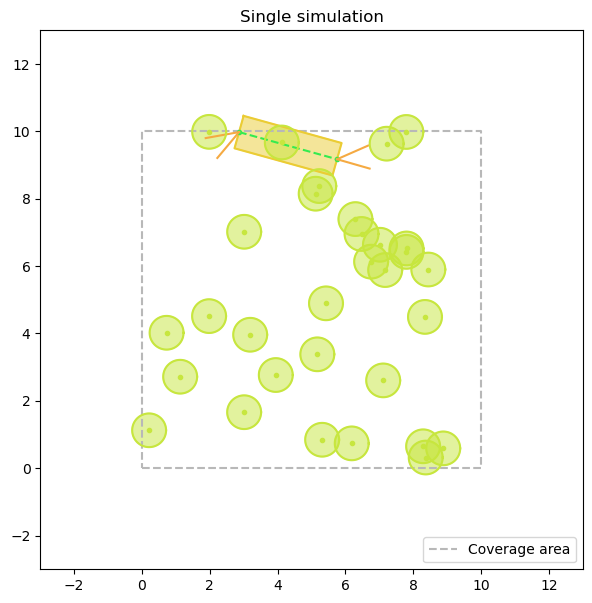

In [13]:
x, y = PoissonProcessInitializer(PoissonParameter, SquareWidth)
Blockators = zip(x, y)

p1a, p2a = np.random.uniform(0, 2*pi), np.random.uniform(0, 2*pi)
p1x, p1y = np.random.uniform(0, SquareWidth), np.random.uniform(0, SquareWidth)
W = np.random.uniform(0, 2*np.pi)
p2x, p2y = p1x + TRDistance*np.cos(W), p1y + TRDistance*np.sin(W)
diagram = Diagram(p1x, p2x, p1y, p2y, p1a, p2a, VisionAngle)

CoverageArea = ((0, SquareWidth, SquareWidth, 0, 0), (0, 0, SquareWidth, SquareWidth, 0))

plt.figure(dpi=100, figsize=(7, 7))
plt.title("Single simulation")

plt.plot(CoverageArea[0], CoverageArea[1], linestyle="dashed", color="#b8b8b8", label="Coverage area")
diagram.Draw()

connection = CheckConnection(diagram, Blockators, 0, 1)
if connection == -3:
    print("Points do not see each other")
elif connection == -2:
    print(f"{p2x, p2y} does not see {p1x, p1y}")
elif connection == -1:
    print(f"{p1x, p1y} does not see {p2x, p2y}")
elif connection == 0:
    print("Line of sight is not blocked")
else:
    print("Line of sight is blocked %i times" % connection)

plt.xlim(-TRDistance, SquareWidth+TRDistance)
plt.ylim(-TRDistance, SquareWidth+TRDistance)
plt.legend(loc="lower right")
plt.show()

### Решение задачи
Участок кода ниже вычисляет приблизительную вероятность блокировки сигнала.

In [10]:
N = 1000
S = 0

for i in range(N):
    x, y = PoissonProcessInitializer(PoissonParameter, SquareWidth)
    Blockators = zip(x, y)

    p1a, p2a = np.random.uniform(0, 2*pi), np.random.uniform(0, 2*pi)
    p1x, p1y = np.random.uniform(0, SquareWidth), np.random.uniform(0, SquareWidth)
    W = np.random.uniform(0, 2*np.pi)
    p2x, p2y = p1x + TRDistance*np.cos(W), p1y + TRDistance*np.sin(W)
    diagram = Diagram(p1x, p2x, p1y, p2y, p1a, p2a, VisionAngle)
    
    if CheckConnection(diagram, Blockators, 0) > 0: S += 1
NoBlock = (1 - S/N) * (VisionAngle / (2 * pi)) ** 2
print("Points are ok with probability of %f" % NoBlock)

Points are ok with probability of 0.012216


Математическое значение вероятности блокировки, которое ожидается получить (при этом блокирование считается, в случае если блокатор находится в участке прямой видимости), вычисляется с помощью участка кода ниже:

In [11]:
# For the complexity I've reached it gets just lower bound
Sb = 2*Radius*TRDistance
MeanNOfBlockators = PoissonParameter * Sb
MathProbability = np.exp(-MeanNOfBlockators) * (VisionAngle / (2 * pi)) ** 2

print("Math probability is %f" % MathProbability)

Math probability is 0.005002


### Вывод
В ходе работы был описан функционал для симулирования работы сети 5G в пределах зоны работы радиостанциии на плоскости. Посредством написанных инструментов была вычислена вероятность экспозиции линии прямой видимости.